## 0. setup device-agnostic code

In [256]:
import torch 
from torch import nn 

torch.__version__

'2.4.0'

In [257]:
# setup device agnostic code 
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Get data

The dataset is a subset of the Food101 dataset. Food101 starts with 101 different classes of food and 1000 images per class (750 training, 250 testing).

Our dataset starts with 3 classes of food and only 10% of the images (~75 training, 25 testing).

**note**: when starting out ML projects, it's important to try things on a small scale and then increase the scale when necessary.

check-out full article - https://www.learnpytorch.io/04_pytorch_custom_datasets/

In [258]:
import requests 
import zipfile 
from pathlib import Path 

# setup path to a data folder 
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

if image_path.is_dir():
    print("folder already exists")
else:
    print("downloading...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f: 
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        f.write(request.content)

folder already exists


In [259]:
image_path

WindowsPath('data/pizza_steak_sushi')

In [260]:
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref: 
    print("unzipping pizza, steak, and sushi data...")
    zip_ref.extractall(image_path)

unzipping pizza, steak, and sushi data...


## 2. Data preparation and data exploration

In [261]:
import os 

def walk_through_dir(dir_path):
    """walks through directory and returning its contents"""
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"there are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

In [262]:
walk_through_dir(image_path)

there are 2 directories and 0 images in data\pizza_steak_sushi
there are 3 directories and 0 images in data\pizza_steak_sushi\test
there are 0 directories and 25 images in data\pizza_steak_sushi\test\pizza
there are 0 directories and 19 images in data\pizza_steak_sushi\test\steak
there are 0 directories and 31 images in data\pizza_steak_sushi\test\sushi
there are 3 directories and 0 images in data\pizza_steak_sushi\train
there are 0 directories and 78 images in data\pizza_steak_sushi\train\pizza
there are 0 directories and 75 images in data\pizza_steak_sushi\train\steak
there are 0 directories and 72 images in data\pizza_steak_sushi\train\sushi


In [263]:
# setup training and testing paths
training_dir = image_path / "train"
testing_dir = image_path / "test"

training_dir, testing_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

### 2.1 visualizing image

1. get all of the image paths
2. pick a random image path using Python's random.choice()
3. get the image class name using `pathlib.Path.parent.stem`
4. open image with Python PIL 
5. show the image and print metadata

In [264]:
import random 
from PIL import Image

# 1. get all image paths 
image_path_list = list(image_path.glob("*/*/*.jpg"))

image_path_list

[WindowsPath('data/pizza_steak_sushi/test/pizza/1152100.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/1503858.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/1687143.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/1925494.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/194643.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/195160.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2003290.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2019408.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2111981.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2124579.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2218680.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2236338.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2508636.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2871261.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/3092704.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/309892.jp

random image path: data\pizza_steak_sushi\test\pizza\1687143.jpg
image class: pizza
image height: 512
image width: 512


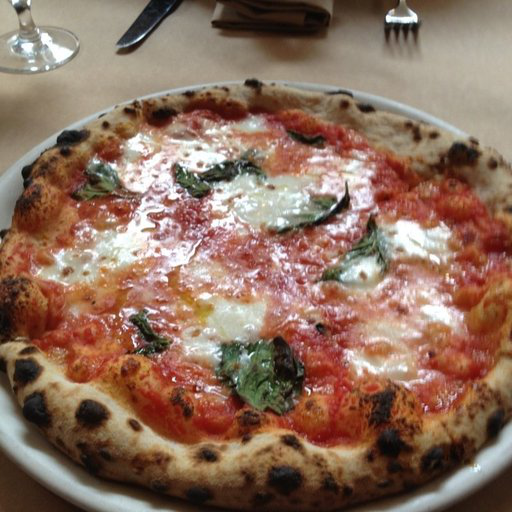

In [265]:
# 2. pick a random image path
random_image_path = random.choice(image_path_list)

# 3. get image class from path name (image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem # will be the class label

# 4. open image
img = Image.open(random_image_path)

# 5. print metada 
print(f"random image path: {random_image_path}")
print(f"image class: {image_class}")
print(f"image height: {img.height}")
print(f"image width: {img.width}")
img

### 2.2 visualizing image with matplotlib

In [266]:
import numpy as np

# turn image into numpy array
img_as_array = np.asarray(Image.open(random_image_path))
img_as_array

array([[[173, 172, 151],
        [176, 175, 154],
        [179, 177, 156],
        ...,
        [141, 133, 114],
        [142, 134, 115],
        [143, 135, 116]],

       [[173, 172, 151],
        [177, 176, 155],
        [180, 178, 157],
        ...,
        [143, 135, 116],
        [143, 135, 116],
        [143, 135, 116]],

       [[175, 174, 153],
        [177, 176, 155],
        [181, 179, 158],
        ...,
        [144, 135, 118],
        [144, 135, 118],
        [144, 135, 118]],

       ...,

       [[ 80,  54,  37],
        [ 78,  52,  35],
        [ 76,  50,  33],
        ...,
        [ 65,  44,  27],
        [ 68,  47,  30],
        [ 70,  49,  32]],

       [[ 82,  56,  39],
        [ 80,  54,  37],
        [ 79,  53,  36],
        ...,
        [ 68,  47,  30],
        [ 70,  49,  30],
        [ 72,  51,  32]],

       [[ 85,  59,  42],
        [ 84,  58,  41],
        [ 83,  57,  40],
        ...,
        [ 70,  49,  30],
        [ 72,  51,  32],
        [ 74,  53,  34]]

Text(0.5, 1.0, 'label: pizza | shape: (512, 512, 3) (H,W,C)')

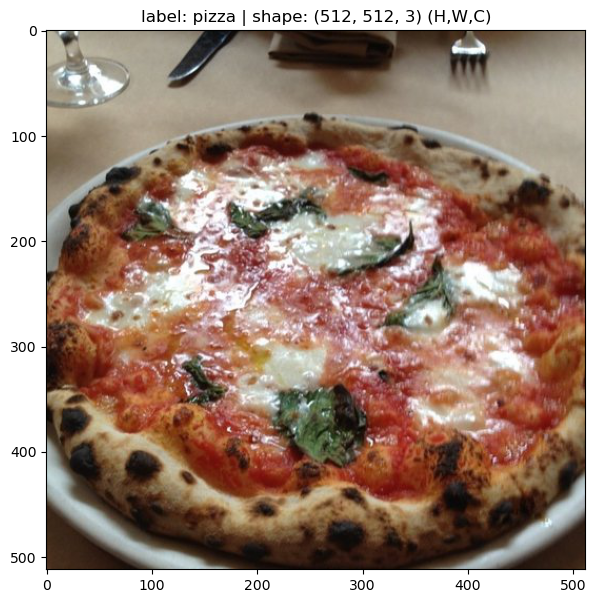

In [267]:
import matplotlib.pyplot as plt 

plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f"label: {image_class} | shape: {img_as_array.shape} (H,W,C)")

## 3. Transforming data

Before we can use our image data with Pytorch: 
1. Turn your target data into tensors (in this case is turning image data into tensors/numerical representation)
2. Turn it into a `torch.utils.data.Dataset` + transforming with ToTensor()
3. Subsequently turn the data into `torch.utils.data.DataLoader` (batch version of the datasets)

In [268]:
from torch.utils.data import DataLoader 
from torchvision import datasets, transforms

### 3.1 Transforming data with `torchvision.transforms`

In [269]:
# write a transform for image 
data_transform = transforms.Compose([
    # resize our images to 64x64
    transforms.Resize(size=(64, 64)),
    # flip the images randomly on the horizontal 
    transforms.RandomHorizontalFlip(p=0.5),
    # turn the image into torch.Tensor 
    # convert PIL image or ndarray (H,W,C) to torch.Tensor with shape (C,H,W)
    transforms.ToTensor()
])

In [270]:
sample = data_transform(img) # the argument expects PIL image
sample

tensor([[[0.7059, 0.6471, 0.4235,  ..., 0.5294, 0.5490, 0.5647],
         [0.7294, 0.6588, 0.4078,  ..., 0.5569, 0.5686, 0.5843],
         [0.7294, 0.7294, 0.6510,  ..., 0.5922, 0.6039, 0.6118],
         ...,
         [0.2627, 0.2471, 0.2353,  ..., 0.1804, 0.1922, 0.2000],
         [0.2784, 0.2588, 0.2471,  ..., 0.1882, 0.1922, 0.2157],
         [0.2863, 0.2627, 0.2549,  ..., 0.2039, 0.2157, 0.2431]],

        [[0.6902, 0.6549, 0.4392,  ..., 0.4863, 0.5137, 0.5294],
         [0.7059, 0.6471, 0.3882,  ..., 0.5216, 0.5333, 0.5451],
         [0.7059, 0.7098, 0.6275,  ..., 0.5608, 0.5765, 0.5843],
         ...,
         [0.1725, 0.1647, 0.1569,  ..., 0.1098, 0.1216, 0.1255],
         [0.1804, 0.1725, 0.1608,  ..., 0.1176, 0.1216, 0.1333],
         [0.1882, 0.1765, 0.1647,  ..., 0.1255, 0.1333, 0.1569]],

        [[0.6118, 0.6235, 0.4235,  ..., 0.4275, 0.4549, 0.4706],
         [0.6275, 0.5804, 0.3373,  ..., 0.4627, 0.4824, 0.4941],
         [0.6235, 0.6314, 0.5569,  ..., 0.5020, 0.5137, 0.

In [271]:
sample.shape # (C, H, W)

torch.Size([3, 64, 64])

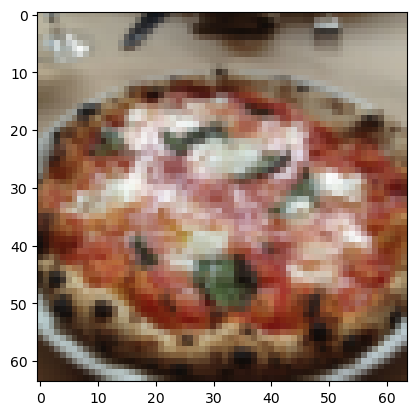

In [272]:
# matplotlib expects image with format shape of (H, W, C) so the tensor should 
# be permuted to follow this form
plt.imshow(torch.permute(sample, (1, 2, 0)))

In [273]:
image_path_list[10]

WindowsPath('data/pizza_steak_sushi/test/pizza/2218680.jpg')

In [274]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    """
    Selects random images from a path of images and loads/transforms them then plots
    the original vs the transformed version
    """
    torch.manual_seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            # original image
            fig, ax = plt.subplots(nrows=1, ncols=2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original\nSize: {f.size}")
            
            # transformed_image
            transformed_image = transform(f).permute(1, 2, 0) # (C,H,W) -> (H,W,C)
            ax[1].imshow(transformed_image) 
            ax[1].set_title(f"Tranformed\nSize: {transformed_image.shape}")

            fig.suptitle(f"Class: {image_path.parent.stem}")

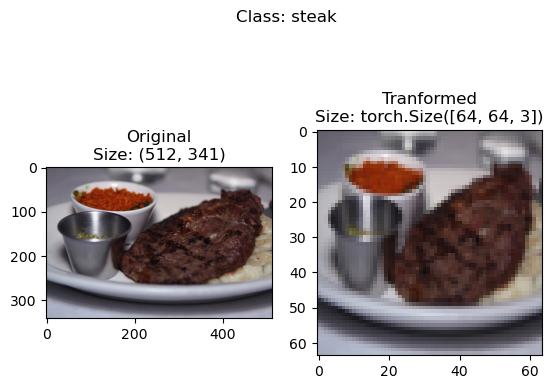

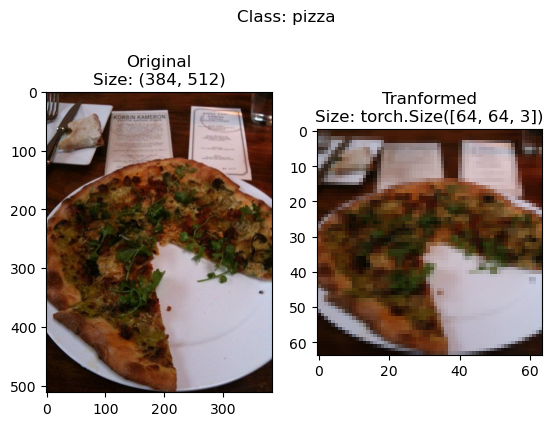

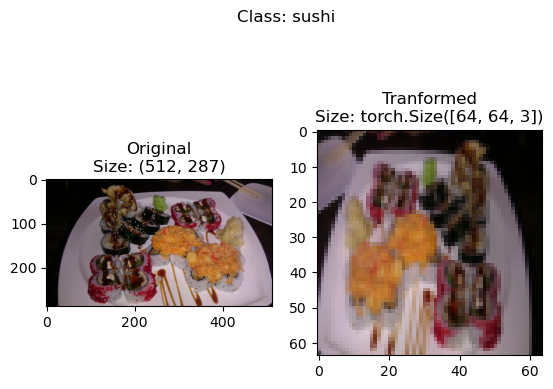

In [275]:
plot_transformed_images(image_paths=image_path_list, transform=data_transform)

## 4. Option 1: Loading image data using `ImageFolder`

docs - https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html

In [276]:
training_dir, testing_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

In [277]:
train_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [278]:
# use ImageFolder to create datasets 
from torchvision import datasets
training_data = datasets.ImageFolder(root=training_dir, 
                                    transform=train_transform, # transform the data
                                    target_transform=None) # transform the label (in this case we don't need this because the label is the parent.stem of the image)

testing_data = datasets.ImageFolder(root=testing_dir,
                                    transform=test_transform)

training_data, testing_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data\pizza_steak_sushi\train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data\pizza_steak_sushi\test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ))

In [279]:
# get class names as a list 
class_names = training_data.classes
class_names

['pizza', 'steak', 'sushi']

In [280]:
# check the length of the datasets 
len(training_data), len(testing_data)

(225, 75)

In [281]:
training_data[0]

(tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
          [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
          [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
          ...,
          [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
          [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0863],
          [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],
 
         [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
          [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0706],
          [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
          ...,
          [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
          [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
          [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],
 
         [[0.0196, 0.0196, 0.0196,  ..., 0.0902, 0.0902, 0.0941],
          [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
          [0.0196, 0.0157, 0.0157,  ...,

In [282]:
# index on the train_data dataset to get a single image and label 
# img, label = training_data[0]
img, label = training_data[0][0], training_data[0][1]
print(f"Image tensor: {img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")

Image tensor: tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0706, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0196, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.01

original shape: torch.Size([3, 64, 64])
permuted shape: torch.Size([64, 64, 3])


Text(0.5, 1.0, 'pizza')

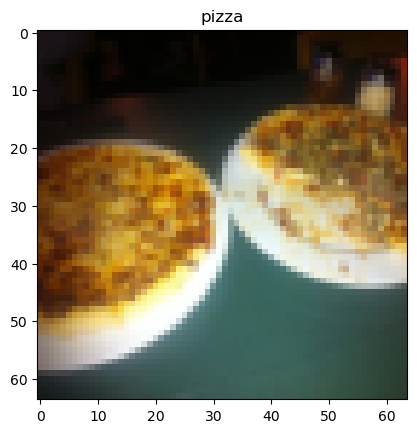

In [283]:
# rearrange the order dimension 
img_permuted = img.permute(1, 2, 0) # (H,W,C)

# print out different shapes 
print(f"original shape: {img.shape}")
print(f"permuted shape: {img_permuted.shape}")

# plot the image
plt.imshow(img_permuted)
plt.title(class_names[label])

## 5. setup dataloader (batch)

A `DataLoader` is used to turn our `Dataset` innto iterables (group of mini-batches) and we can customize the `BATCH_SIZE` so our model can see multiple images at a time (batch).

In [284]:
import os 
os.cpu_count()

16

In [287]:
BATCH_SIZE = 32

training_dataloader = DataLoader(dataset=training_data, 
                                batch_size=BATCH_SIZE, 
                                shuffle=True)

testing_dataloader = DataLoader(dataset=testing_data,
                                batch_size=BATCH_SIZE, 
                                shuffle=False)

In [288]:
a, b = next(iter(training_dataloader))
a.shape # [batch_size, color_channels, height, width]

torch.Size([32, 3, 64, 64])